<a href="https://colab.research.google.com/github/muckitymuck/model_fitting/blob/main/Model_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
#Read in data, need to tab seperapte since content_string has commas in it
data1 = pd.read_csv("RC-ML-MODEL-DATA.txt", sep = "\t", encoding = 'ISO-8859-1')
data2 = pd.read_csv("RC-ML-MODEL-DATA-02.txt", sep = "\t", encoding = 'ISO-8859-1')
tickets = pd.concat([data1,data2])

In [ ]:
#drop a bunch of columns that would be made after the identification and resolution ratings
cols_to_select = list(range(1, 21))
tickets = tickets.iloc[:, cols_to_select]

In [ ]:
# one-hot encode note aggregations and content_keyword string
tickets[['note_aggregation_level1', 'note_aggregation_level2', 'content_keyword_string']] = tickets[['note_aggregation_level1', 'note_aggregation_level2', 'content_keyword_string']].apply(lambda x: x.str.replace(' ', '').str.split('+'))
for i in ['note_aggregation_level1', 'note_aggregation_level2', 'content_keyword_string']:
  one_hot = pd.get_dummies(tickets[i].apply(pd.Series).stack()).sum(level=0)
  tickets = pd.concat([tickets, one_hot], axis=1)
tickets.drop(columns = ['note_aggregation_level1', 'note_aggregation_level2', 'content_keyword_string'], inplace=True)

<ipython-input-8-b7abb367210c>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  one_hot = pd.get_dummies(tickets[i].apply(pd.Series).stack()).sum(level=0)
<ipython-input-8-b7abb367210c>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  one_hot = pd.get_dummies(tickets[i].apply(pd.Series).stack()).sum(level=0)
<ipython-input-8-b7abb367210c>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  one_hot = pd.get_dummies(tickets[i].apply(pd.Series).stack()).sum(level=0)


In [ ]:
#get data ready for models
X = tickets.drop(['problem_rating_identifitication', 'problem_rating_resolution', 'content_string', 'category_id', 'category', 'user_id', 'created_on', 'created_year', 'created_month', 'created_day', 'created_dayname',
                  'language', 'sentiment', 'note', 'response_first'], axis =1)
#If content_keyword_string or note_aggregation_level1 or note_aggregation_level2 is null then zero for all categories
X = X.fillna(0).astype('int')
Y = tickets[['problem_rating_identifitication', 'problem_rating_resolution']]

In [ ]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Check shapes of X_train and Y_train
print(X_train.shape)  # Output: (num_samples, num_features)
print(Y_train['problem_rating_identifitication'].shape)  # Output: (num_samples,)

(15008, 50)
(15008,)


#Logit

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

## ID

In [ ]:
#fit model
ID_mod = OrderedModel(Y_train['problem_rating_identifitication'],X_train, dist = 'logit')
ID_prob = ID_mod.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 0.644586
         Iterations: 272
         Function evaluations: 278
         Gradient evaluations: 278


In [ ]:
#test model
ID_test = ID_mod.predict(ID_prob.params, exog = X_test)
#go from probabilities to prediction
ID_class =  np.argmax(ID_test, axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [ ]:
#calculate accuracy and accuracy when off by one
cm = confusion_matrix(Y_test['problem_rating_identifitication'], ID_class)
print(cm)
print(np.trace(cm) / float(np.sum(cm)))
off_by_one = np.sum([cm[i, j] for i in range(6) for j in range(6) if abs(i - j) == 1])
print((np.trace(cm)+off_by_one)/float(np.sum(cm)))

[[   0    0    2    0    0    0]
 [   0 2367  287    0    0    2]
 [   0  233  613    0    0    1]
 [   0   37   83    0    0    5]
 [   0   14   23    0    0    1]
 [   0   15   67    0    0    2]]
0.7947761194029851
0.9557569296375267


In [ ]:
#make a null classifier for comparison
null = confusion_matrix(Y_test['problem_rating_identifitication'], np.zeros(len(Y_test))+1)
print(null)
print(np.trace(null) / float(np.sum(null)))

[[   0    2    0    0    0    0]
 [   0 2656    0    0    0    0]
 [   0  847    0    0    0    0]
 [   0  125    0    0    0    0]
 [   0   38    0    0    0    0]
 [   0   84    0    0    0    0]]
0.7078891257995735


## Resolution

In [ ]:
# Check shapes of X_train and Y_train
print(X_train.shape)  # Output: (num_samples, num_features)
print(Y_train['problem_rating_identifitication'].shape)  # Output: (num_samples,)

(15008, 50)
(15008,)


In [ ]:
#fit model
Reso_mod = OrderedModel(Y_train['problem_rating_resolution'],X_train, dist = 'logit')
Reso_prob = Reso_mod.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 0.657193
         Iterations: 361
         Function evaluations: 365
         Gradient evaluations: 365


In [ ]:
#test model
Reso_test = Reso_mod.predict(Reso_prob.params, exog = X_test)
Reso_class = max_indices = np.argmax(Reso_test, axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [ ]:
#Calculate accuracy and accuracy off by one
cm = confusion_matrix(Y_test['problem_rating_resolution'], Reso_class)
print("predictions")
print(cm)
print(np.trace(cm) / float(np.sum(cm)))
off_by_one = np.sum([cm[i, j] for i in range(6) for j in range(6) if abs(i - j) == 1])
print((np.trace(cm)+off_by_one)/float(np.sum(cm)))

predictions
[[   0    2    0    0    0    0]
 [   0 2898   17    2    0    3]
 [   0  387   44    4    0    7]
 [   0  190   41    4    0   16]
 [   0   60    4    2    0    2]
 [   0   40   20    4    0    5]]
0.7865138592750534
0.9077825159914712


In [ ]:
#make null predictor to compare against
null = confusion_matrix(Y_test['problem_rating_resolution'], np.zeros(len(Y_test))+1)
print(null)
print(np.trace(null) / float(np.sum(null)))

[[   0    2    0    0    0    0]
 [   0 2920    0    0    0    0]
 [   0  442    0    0    0    0]
 [   0  251    0    0    0    0]
 [   0   68    0    0    0    0]
 [   0   69    0    0    0    0]]
0.7782515991471215


# Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Get validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=43)

### ID

In [ ]:
#set network structure
keras.utils.set_random_seed(14)
network = keras.models.Sequential([
      keras.layers.Dense(256, activation = 'relu',input_shape=(50,)),
      keras.layers.Dense(256, activation = "relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(128, activation = 'relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(6, activation="softmax")
])

In [ ]:
#compile network
network.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.005),
                metrics = ["accuracy"])

In [ ]:
#fit network
history = network.fit(X_train, Y_train['problem_rating_identifitication'],
                      epochs=10, batch_size=32,
                      validation_data=(X_valid, Y_valid['problem_rating_identifitication']))

Epoch 1/10
376/376 [==============================] - 4s 7ms/step - loss: 1.3702 - accuracy: 0.6723 - val_loss: 0.7662 - val_accuracy: 0.7062
Epoch 2/10
376/376 [==============================] - 3s 7ms/step - loss: 0.7973 - accuracy: 0.7063 - val_loss: 0.7477 - val_accuracy: 0.7165
Epoch 3/10
376/376 [==============================] - 3s 8ms/step - loss: 0.7738 - accuracy: 0.7199 - val_loss: 0.7042 - val_accuracy: 0.7482
Epoch 4/10
376/376 [==============================] - 2s 6ms/step - loss: 0.7078 - accuracy: 0.7543 - val_loss: 0.5665 - val_accuracy: 0.7871
Epoch 5/10
376/376 [==============================] - 2s 7ms/step - loss: 0.6246 - accuracy: 0.7776 - val_loss: 0.5563 - val_accuracy: 0.7961
Epoch 6/10
376/376 [==============================] - 2s 7ms/step - loss: 0.6344 - accuracy: 0.7744 - val_loss: 0.5619 - val_accuracy: 0.8085
Epoch 7/10
376/376 [==============================] - 3s 7ms/step - loss: 0.6070 - accuracy: 0.7840 - val_loss: 0.5781 - val_accuracy: 0.7868
Epoch 

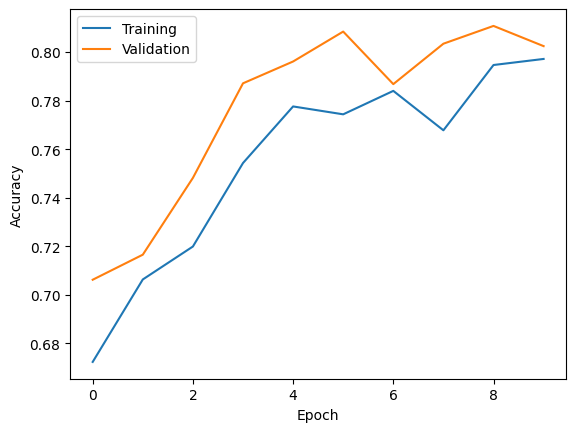

In [ ]:
#look at accuracy of network
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#look at class predictions to check for spread
preds = np.argmax(network.predict(X_test), axis = 1)
vals, counts = np.unique(preds, return_counts = True)
print(vals)
print(counts)

118/118 [==============================] - 0s 2ms/step
[0 1 2 5]
[   3 2554 1151   44]


In [ ]:
#calculate prediction accuracy and accuracy off by one
cm = confusion_matrix(Y_test['problem_rating_identifitication'], preds)
print("predictions")
print(cm)
print(np.trace(cm) / float(np.sum(cm)))
off_by_one = np.sum([cm[i, j] for i in range(6) for j in range(6) if abs(i - j) == 1])
print((np.trace(cm)+off_by_one)/float(np.sum(cm)))

predictions
[[   2    0    0    0    0    0]
 [   1 2311  344    0    0    0]
 [   0  184  662    0    0    1]
 [   0   36   88    0    0    1]
 [   0   12   25    0    0    1]
 [   0   11   32    0    0   41]]
0.8038379530916845
0.9685501066098081


### Resolution

In [ ]:
#set network stucture
keras.utils.set_random_seed(2)
network = keras.models.Sequential([
      keras.layers.Dense(256, activation = 'relu',input_shape=(50,)),
      keras.layers.Dense(256, activation = "relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(128, activation = 'relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(6, activation="softmax")
])

In [ ]:
#compile network
network.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.005),
                metrics = ["accuracy"]) ##errors,algorithm,accuracy

In [ ]:
#fit network
history = network.fit(X_train, Y_train['problem_rating_resolution'],
                      epochs=15, batch_size=32,
                      validation_data=(X_valid, Y_valid['problem_rating_resolution']))

Epoch 1/15
376/376 [==============================] - 4s 9ms/step - loss: 1.3339 - accuracy: 0.7409 - val_loss: 0.7409 - val_accuracy: 0.7831
Epoch 2/15
376/376 [==============================] - 2s 6ms/step - loss: 0.7575 - accuracy: 0.7724 - val_loss: 0.7165 - val_accuracy: 0.7868
Epoch 3/15
376/376 [==============================] - 2s 7ms/step - loss: 0.7577 - accuracy: 0.7738 - val_loss: 0.7157 - val_accuracy: 0.7875
Epoch 4/15
376/376 [==============================] - 2s 7ms/step - loss: 0.7534 - accuracy: 0.7746 - val_loss: 0.7176 - val_accuracy: 0.7868
Epoch 5/15
376/376 [==============================] - 3s 7ms/step - loss: 0.7614 - accuracy: 0.7741 - val_loss: 0.6889 - val_accuracy: 0.7875
Epoch 6/15
376/376 [==============================] - 3s 9ms/step - loss: 0.7656 - accuracy: 0.7739 - val_loss: 0.7139 - val_accuracy: 0.7871
Epoch 7/15
376/376 [==============================] - 2s 6ms/step - loss: 0.7474 - accuracy: 0.7756 - val_loss: 0.7231 - val_accuracy: 0.7868
Epoch 

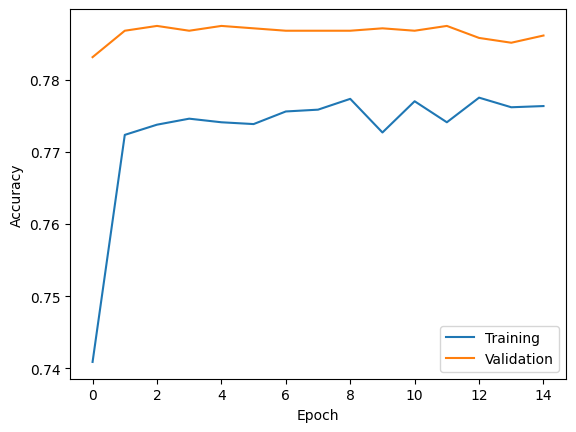

In [ ]:
#plot accuracies to see trends
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#check spread
preds = np.argmax(network.predict(X_test), axis = 1)
vals, counts = np.unique(preds, return_counts = True)
print(vals)
print(counts)

118/118 [==============================] - 1s 3ms/step
[0 1 2 5]
[   3 3686    5   58]


In [ ]:
#calculate prediction accuracy and accuracy off by one
cm = confusion_matrix(Y_test['problem_rating_resolution'], preds)
print("predictions")
print(cm)
print(np.trace(cm) / float(np.sum(cm)))
off_by_one = np.sum([cm[i, j] for i in range(6) for j in range(6) if abs(i - j) == 1])
print((np.trace(cm)+off_by_one)/float(np.sum(cm)))

predictions
[[   2    0    0    0    0    0]
 [   1 2917    1    0    0    1]
 [   0  436    3    0    0    3]
 [   0  249    0    0    0    2]
 [   0   66    0    0    0    2]
 [   0   18    1    0    0   50]]
0.7921108742004265
0.9093816631130064
